In [129]:
import os
from pprint import pprint

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import catboost as cb

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [5]:
def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [6]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/test_data.csv")

In [7]:
def plot_box(dataframe, column_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(dataframe[column_name], vert=False)
    plt.xlabel(column_name)
    plt.title(f'Box Plot of {column_name}')
    plt.show()
    
def value_counts_ratio_count(df, col_name, target_name):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))
    

def summarize_grouped_data(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)
    
    return results_df
  
  
def plot_abnormal_ratio(dataframe, column_name, target_name, target_value, bins=20):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하고 막대그래프로 표시하는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    target_value (str): 타겟 변수의 특정 값
    bins (int): 구간의 수 (기본값은 20)
    """
    def abnormal_ratio(dataframe, column_name, target_name, target_value):
        """
        주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하는 함수.

        Parameters:
        dataframe (pd.DataFrame): 데이터프레임
        column_name (str): 열 이름
        target_name (str): 타겟 변수 이름
        target_value (str): 타겟 변수의 특정 값

        Returns:
        pd.DataFrame: 각 값마다 타겟 변수의 특정 값 비율을 포함하는 데이터프레임
        """
        # 각 값마다 타겟 변수의 특정 값 비율 계산
        value_counts = dataframe.groupby(column_name)[target_name].apply(lambda x: (x == target_value).mean()).reset_index()
        count_counts = dataframe.groupby(column_name)[target_name].count().reset_index()
        
        value_counts.columns = [column_name, 'ratio']
        count_counts.columns = [column_name, 'count']
        
        # 비율과 카운트를 병합
        result = pd.merge(value_counts, count_counts, on=column_name)
        return result

    # column_name 값을 지정된 구간으로 나누기
    dataframe[f'{column_name}_bins'] = pd.cut(dataframe[column_name], bins=bins)

    # 비율 계산
    ratios = abnormal_ratio(dataframe, f'{column_name}_bins', target_name, target_value)

    # 막대그래프 그리기
    plt.figure(figsize=(20, 10))
    barplot = sns.barplot(x=f'{column_name}_bins', y='ratio', data=ratios, color='skyblue')
    plt.xlabel(f'{column_name} (binned)')
    plt.ylabel('AbNormal Ratio')
    plt.title(f'AbNormal Ratio by {column_name} (binned)', pad=30)  # 제목과 그래프 사이의 간격 조정
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # 각 막대 위에 비율 값과 카운트 표시
    for p in barplot.patches:
        # 막대의 x 좌표에 해당하는 구간을 찾기
        bin_label = ratios[f'{column_name}_bins'].cat.categories[int(p.get_x() + p.get_width() / 2) - 1]
        count_value = ratios.loc[ratios[f'{column_name}_bins'] == bin_label, 'count'].values[0]
        barplot.annotate(f'{format(p.get_height(), ".2f")} ({count_value})', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')

    plt.show()

    # _bins 변수 드랍
    dataframe.drop(columns=[f'{column_name}_bins'], inplace=True)
    
    
# train_data와 test_data에서 '?'를 포함하는 열 이름 필터링
train_Process_Desc_col = train_data.filter(like='?').columns
test_Process_Desc_col = test_data.filter(like='?').columns

# 필터링된 열 이름 출력
print("<? column in train_data>")
for col in train_Process_Desc_col:
    print(col)

print("<? column in test_data>")
for col in test_Process_Desc_col:
    print(col)

# ? -> Θ로 변경할 열 이름과 새 열 이름 생성
train_new_columns = {col: col.replace('?', 'Θ') for col in train_Process_Desc_col}
test_new_columns = {col: col.replace('?', 'Θ') for col in test_Process_Desc_col}

# 열 이름 변경
train_data.rename(columns=train_new_columns, inplace=True)
test_data.rename(columns=test_new_columns, inplace=True)

# 'Θ'를 포함하는 열 이름 필터링
train_Process_Desc_col = train_data.filter(like='Θ').columns
test_Process_Desc_col = test_data.filter(like='Θ').columns

# 필터링된 열 이름 출력
print("<Θ in train_data>")
print("train_data:")
for col in train_Process_Desc_col:
    print(col)

print("test_data:")
for col in test_Process_Desc_col:
    print(col)
    
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<? column in train_data>
<? column in test_data>
<Θ in train_data>
train_data:
CURE END POSITION Θ Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
test_data:
CURE END POSITION Θ Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NOR

In [8]:
# 'Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(

Dispenser_num 변수 정리

In [9]:
# Dispenser_num 값에 따라 원핫인코딩 변수 생성
train_data['Dispenser_1'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
train_data['Dispenser_2'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

test_data['Dispenser_1'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
test_data['Dispenser_2'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

# 결과 확인
print(train_data[['Dispenser_num', 'Dispenser_1', 'Dispenser_2']].head(5))

# 불필요한 변수 제거
train_data.drop(['Dispenser_num'], axis=1, inplace=True)
test_data.drop(['Dispenser_num'], axis=1, inplace=True)

  Dispenser_num  Dispenser_1  Dispenser_2
0            #1            1            0
1            #1            1            0
2            #2            0            1
3            #2            0            1
4            #1            1            0


Workorder 변수

In [10]:
# 파생변수 생성: workorder 앞 4자리 -> workorder_prefix
train_data['workorder_prefix'] = train_data['Workorder'].str[:4]
test_data['workorder_prefix'] = test_data['Workorder'].str[:4]

In [11]:
train_data = train_data.drop(columns='Workorder')
test_data = test_data.drop(columns='Workorder')

Receip 변수

In [12]:
# 파생변수 생성: 3개의 컬럼 값이 모두 동일하면 해당 값을 저장, 아니면 diff
train_data['Receip_No'] = train_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 0,
    axis=1
)
test_data['Receip_No'] = test_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 0,
    axis=1
)

train_data['Receip_No'].value_counts()

Receip_No
1     39276
6       980
9        96
17       86
3        64
0         4
Name: count, dtype: int64

In [13]:
columns_to_drop = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']

train_data = train_data.drop(columns=columns_to_drop, inplace=False)
test_data = test_data.drop(columns=columns_to_drop, inplace=False)

Workmode 변수

In [14]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

Pallete ID 변수

In [15]:
# 결과 확인
summarize_group(train_data,[
    'PalletID Collect Result_Dam'
    , 'PalletID Collect Result_Fill1'
    , 'PalletID Collect Result_Fill2'])

Grouped by: PalletID Collect Result_Dam, PalletID Collect Result_Fill1, PalletID Collect Result_Fill2

           group  'AdNormal' count     ratio  Total
0      (1, 1, 1)               162  0.051494   3146
1      (1, 1, 4)                 1  1.000000      1
2      (1, 1, 7)                 1  1.000000      1
3      (1, 1, 9)                 1  1.000000      1
4      (1, 2, 2)                 1  1.000000      1
..           ...               ...       ...    ...
87  (16, 10, 10)                 1  1.000000      1
88  (16, 15, 15)                 1  1.000000      1
89   (16, 16, 8)                 1  1.000000      1
90  (16, 16, 11)                 1  1.000000      1
91  (16, 16, 16)               110  0.062007   1774

[92 rows x 4 columns]


In [16]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['PalletID_Collect_Result'] = df.apply(
        lambda row: row['PalletID Collect Result_Dam'] 
                    if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [17]:
# 제거할 변수 목록
columns_to_drop = [
    'PalletID Collect Result_Dam',
    'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

Production Qty 변수

In [18]:
# 결과 확인
summarize_group(train_data,[
    'Production Qty Collect Result_Dam'
    , 'Production Qty Collect Result_Fill1'
    , 'Production Qty Collect Result_Fill2'])

Grouped by: Production Qty Collect Result_Dam, Production Qty Collect Result_Fill1, Production Qty Collect Result_Fill2

               group  'AdNormal' count     ratio  Total
0          (0, 0, 0)                13  0.141304     92
1         (0, 0, 12)                 1  1.000000      1
2        (0, 0, 300)                 1  1.000000      1
3          (0, 2, 2)                 1  1.000000      1
4        (0, 19, 19)                 1  1.000000      1
..               ...               ...       ...    ...
695  (604, 604, 604)                 0  0.000000      1
696  (605, 605, 605)                 0  0.000000      1
697  (606, 606, 606)                 0  0.000000      1
698  (607, 607, 607)                 0  0.000000      1
699  (608, 608, 608)                 0  0.000000      1

[700 rows x 4 columns]


In [19]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['Production_Qty_Collect_Result'] = df.apply(
        lambda row: row['Production Qty Collect Result_Dam'] 
                    if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [20]:
train_data['Production_Qty_Collect_Result'].value_counts()

Production_Qty_Collect_Result
0      185
8      147
14     146
28     145
30     144
      ... 
589      1
604      1
598      1
608      1
576      1
Name: count, Length: 607, dtype: int64

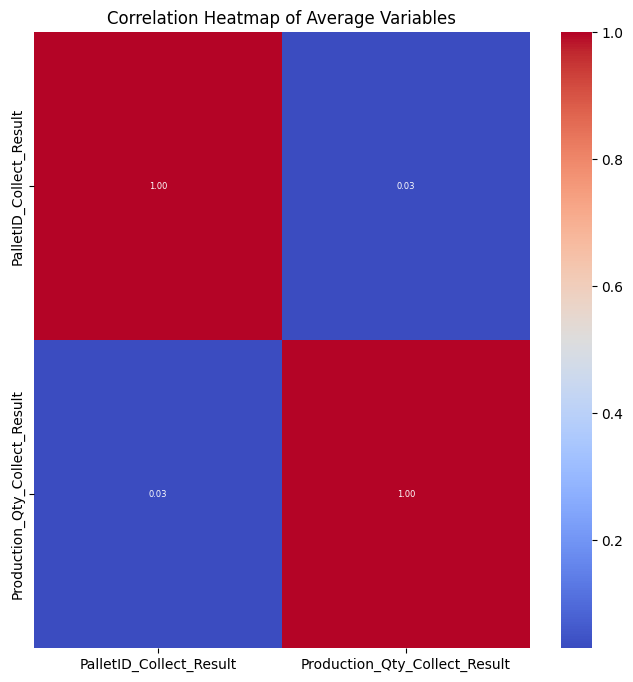

In [21]:
# 상관계수
variables = [
    'PalletID_Collect_Result',
    'Production_Qty_Collect_Result'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

Judge value 변수

In [22]:
# 'Judge'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Judge').columns

# 필터링된 열 이름 출력
print("<Judge 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Judge 공정 관련 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2


In [23]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### Dam 변수

In [24]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Z AX

In [25]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

In [26]:
train_data['CURE_DISTANCE_Dam'].value_counts()

CURE_DISTANCE_Dam
790.607994    25030
720.306185    15476
Name: count, dtype: int64

In [27]:
summarize_grouped_data(train_data, 'CURE_DISTANCE_Dam')

Grouped by: C, U, R, E, _, D, I, S, T, A, N, C, E, _, D, a, m

        group  'AdNormal' count     ratio  Total
0  720.306185               865  0.055893  15476
1  790.607994              1485  0.059329  25030


,group,'AdNormal' count,ratio,Total
0,720.306185,865,0.055893,15476
1,790.607994,1485,0.059329,25030


In [28]:
# 변수 제거
train_data.drop(columns=[
    'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'
    , 'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION X Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
], inplace=True)

test_data.drop(columns=[
    'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'
    , 'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION X Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
], inplace=True)

In [29]:
train_data['CURE_Time_Dam'] = train_data['CURE_DISTANCE_Dam'] / train_data['CURE SPEED Collect Result_Dam']
test_data['CURE_Time_Dam'] = test_data['CURE_DISTANCE_Dam'] / test_data['CURE SPEED Collect Result_Dam']

In [30]:
train_data.drop(columns=[
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
], inplace=True)

test_data.drop(columns=[
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
], inplace=True)

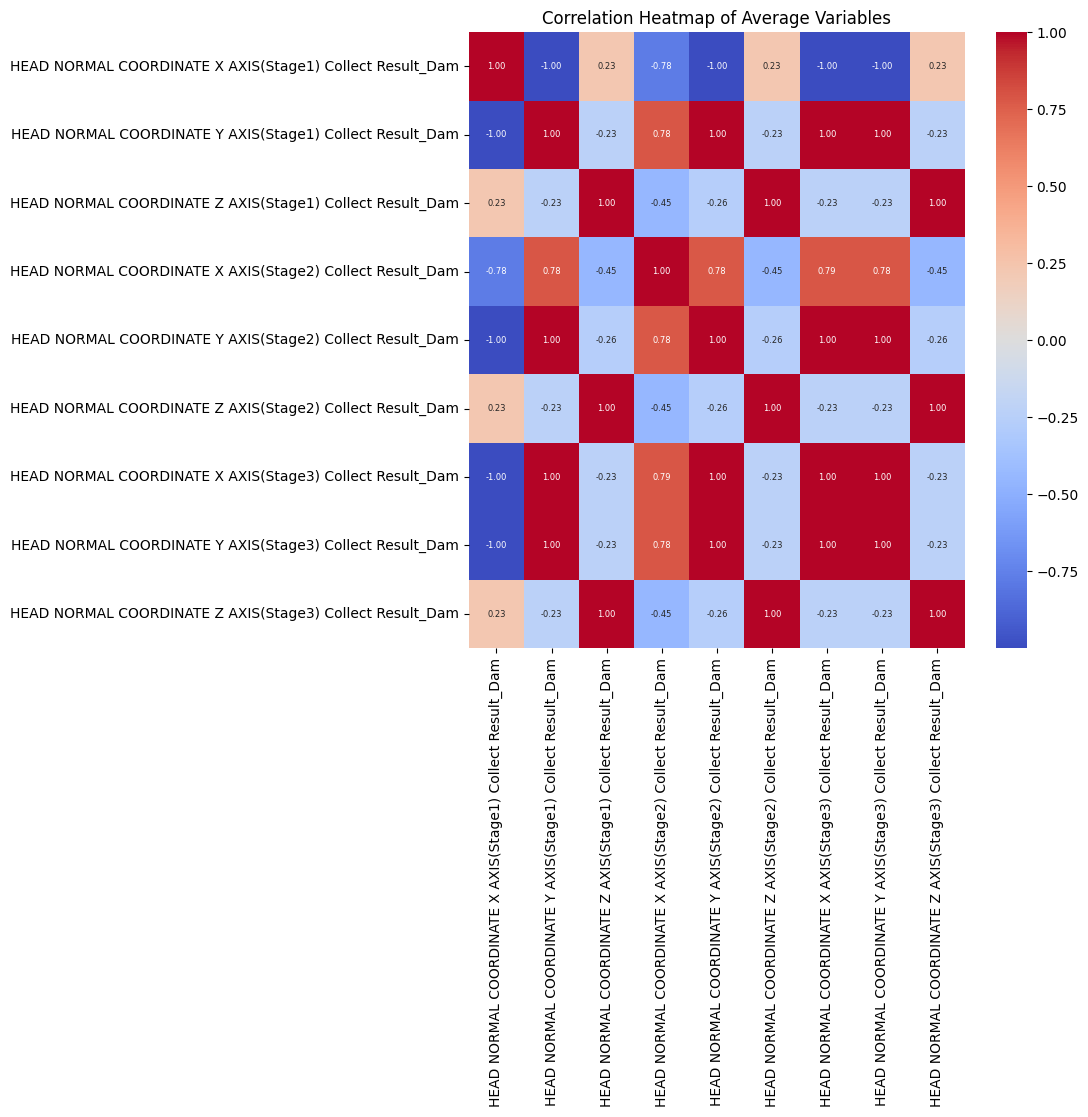

In [31]:
# 상관계수
variables = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [32]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

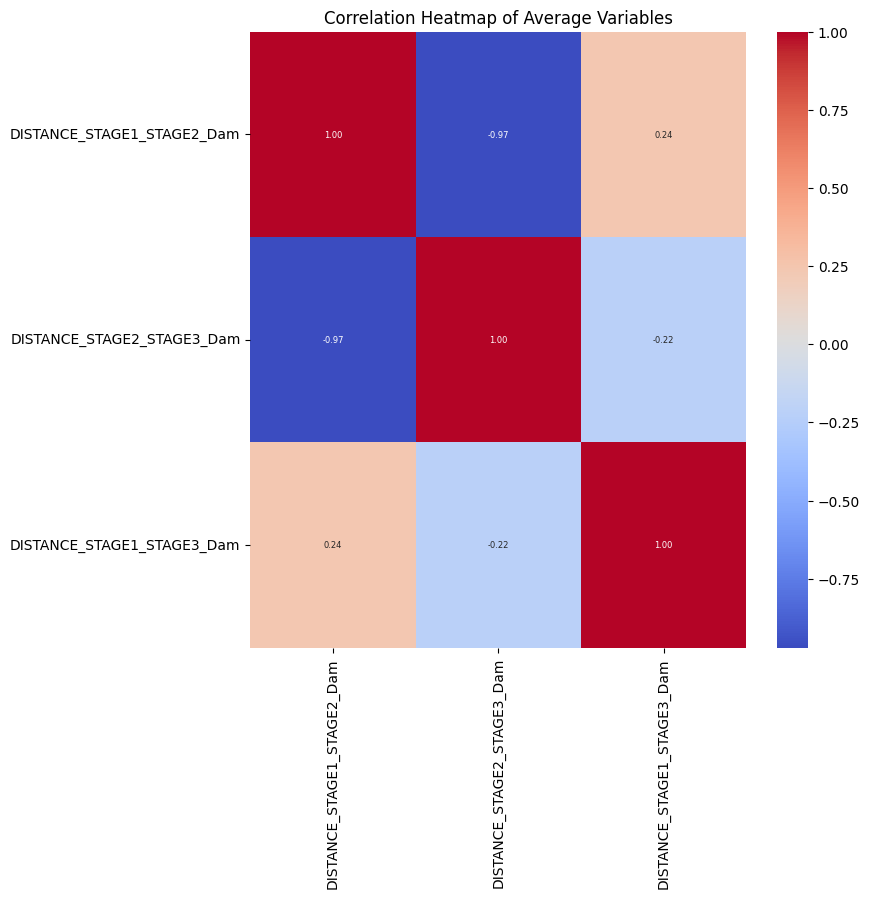

In [33]:
# 상관계수
variables = [
    'DISTANCE_STAGE1_STAGE2_Dam',
    'DISTANCE_STAGE2_STAGE3_Dam',
    'DISTANCE_STAGE1_STAGE3_Dam'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [34]:
# '_Dam'를 포함하는 열 이름 필터링 함수
def filter_dam_columns(data):
    return data.filter(like='_Dam').columns

# 스테이지별로 파생변수 생성 함수
def create_stage_variables(data, columns):
    stages = ['Stage1', 'Stage2', 'Stage3']
    for stage in stages:
        stage_cols = [col for col in columns if stage in col]
        new_col_name = f'{stage}_Total_Distance_Speed_Collect_Result_Dam'
        data[new_col_name] = data[stage_cols].sum(axis=1)
        # 이전 변수 삭제
        data.drop(columns=stage_cols, inplace=True)
    return data

# train_data에 적용
train_dam_columns = filter_dam_columns(train_data)
train_data = create_stage_variables(train_data, train_dam_columns)

# test_data에 적용
test_dam_columns = filter_dam_columns(test_data)
test_data = create_stage_variables(test_data, test_dam_columns)

In [35]:
# 새로운 파생변수 생성 함수
def create_total_thickness_dam(data):
    data['Total_THICKNESS_Collect_Result_Dam'] = (
        data['THICKNESS 1 Collect Result_Dam']**2 
        + data['THICKNESS 2 Collect Result_Dam']**2 
        + data['THICKNESS 3 Collect Result_Dam']**2
    )
    # 기존 변수 삭제
    data.drop(columns=[
        'THICKNESS 1 Collect Result_Dam',
        'THICKNESS 2 Collect Result_Dam',
        'THICKNESS 3 Collect Result_Dam'
    ], inplace=True)
    return data

train_data = create_total_thickness_dam(train_data)
test_data = create_total_thickness_dam(test_data)

In [36]:
# 삭제할 열 이름 정의
columns_to_drop = [
   # 'DISTANCE_STAGE1_STAGE2_Dam'
    'DISTANCE_STAGE2_STAGE3_Dam'
    # , 'DISTANCE_STAGE1_STAGE3_Dam'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [37]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
Production Qty Collect Result_Dam
CURE_Time_Dam
DISTANCE_STAGE1_STAGE2_Dam
DISTANCE_STAGE1_STAGE3_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam
Total_THICKNESS_Collect_Result_Dam


In [38]:
train_data['All_Total_Distance_Speed_Collect_Result_Dam'] = train_data['Stage1_Total_Distance_Speed_Collect_Result_Dam'] + train_data['Stage2_Total_Distance_Speed_Collect_Result_Dam'] + train_data['Stage3_Total_Distance_Speed_Collect_Result_Dam']
test_data['All_Total_Distance_Speed_Collect_Result_Dam'] = test_data['Stage1_Total_Distance_Speed_Collect_Result_Dam'] + test_data['Stage2_Total_Distance_Speed_Collect_Result_Dam'] + test_data['Stage3_Total_Distance_Speed_Collect_Result_Dam']

train_data['Distance_frac_time_Dam'] = train_data['All_Total_Distance_Speed_Collect_Result_Dam'] / train_data['Machine Tact time Collect Result_Dam']
test_data['Distance_frac_time_Dam'] = test_data['All_Total_Distance_Speed_Collect_Result_Dam'] / test_data['Machine Tact time Collect Result_Dam']

# 삭제할 열 이름 정의
columns_to_drop = [
    # 'Machine Tact time Collect Result_Dam'
    # , 'Stage1_Total_Distance_Speed_Collect_Result_Dam'
    # , 'Stage2_Total_Distance_Speed_Collect_Result_Dam'
    # , 'Stage3_Total_Distance_Speed_Collect_Result_Dam'
     'All_Total_Distance_Speed_Collect_Result_Dam'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [39]:
train_data['Stage1_Total_Distance_Speed_Collect_Result_Dam'].value_counts()

Stage1_Total_Distance_Speed_Collect_Result_Dam
73221.570    4248
73221.670    2917
33739.140    2009
53730.963    1499
41227.640    1431
             ... 
50817.250       1
47936.460       1
47935.960       1
47935.070       1
47926.440       1
Name: count, Length: 158, dtype: int64

In [40]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
Production Qty Collect Result_Dam
CURE_Time_Dam
DISTANCE_STAGE1_STAGE2_Dam
DISTANCE_STAGE1_STAGE3_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam
Total_THICKNESS_Collect_Result_Dam
Distance_frac_time_Dam


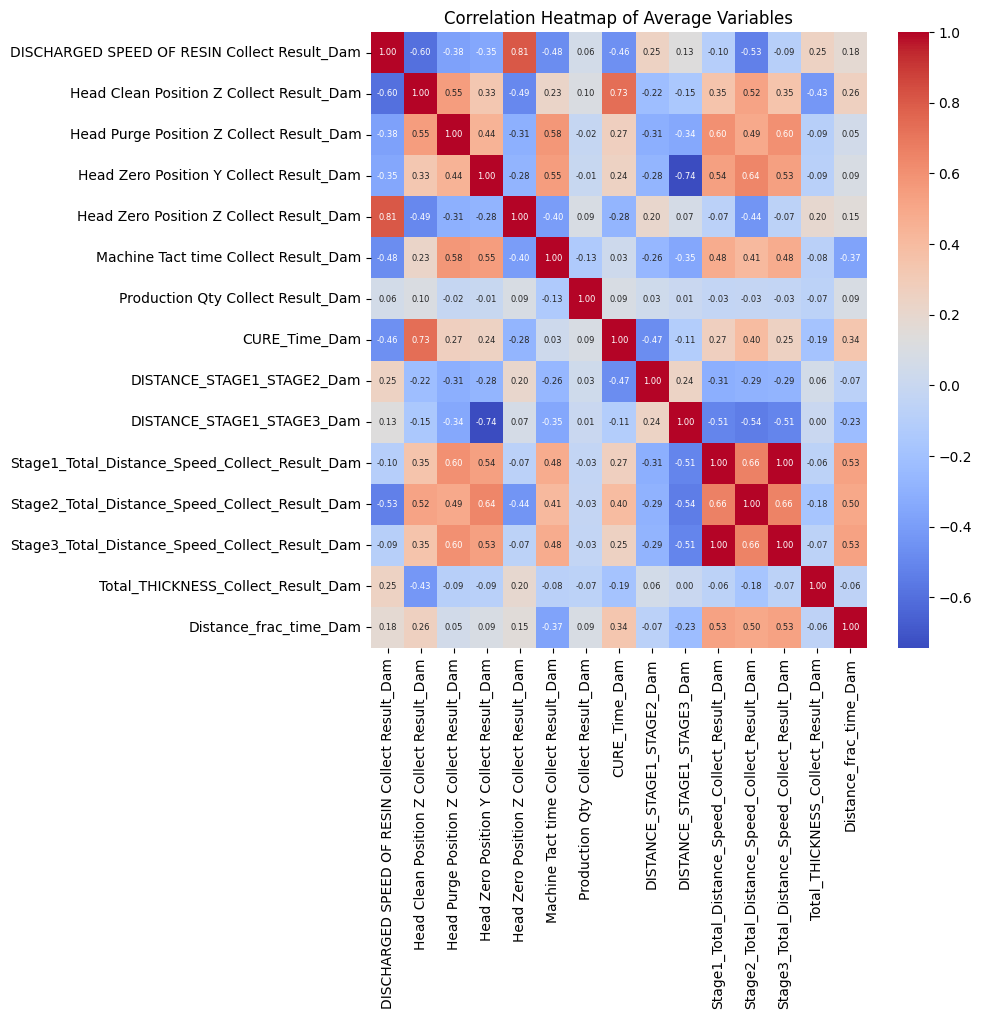

In [41]:
# 상관계수
variables = [
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
'Head Clean Position Z Collect Result_Dam',
'Head Purge Position Z Collect Result_Dam',
'Head Zero Position Y Collect Result_Dam',
'Head Zero Position Z Collect Result_Dam',
'Machine Tact time Collect Result_Dam',
'Production Qty Collect Result_Dam',
'CURE_Time_Dam',
'DISTANCE_STAGE1_STAGE2_Dam',
'DISTANCE_STAGE1_STAGE3_Dam',
'Stage1_Total_Distance_Speed_Collect_Result_Dam',
'Stage2_Total_Distance_Speed_Collect_Result_Dam',
'Stage3_Total_Distance_Speed_Collect_Result_Dam',
'Total_THICKNESS_Collect_Result_Dam',
'Distance_frac_time_Dam'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

### Autoclave

In [42]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
1st Pressure 1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave


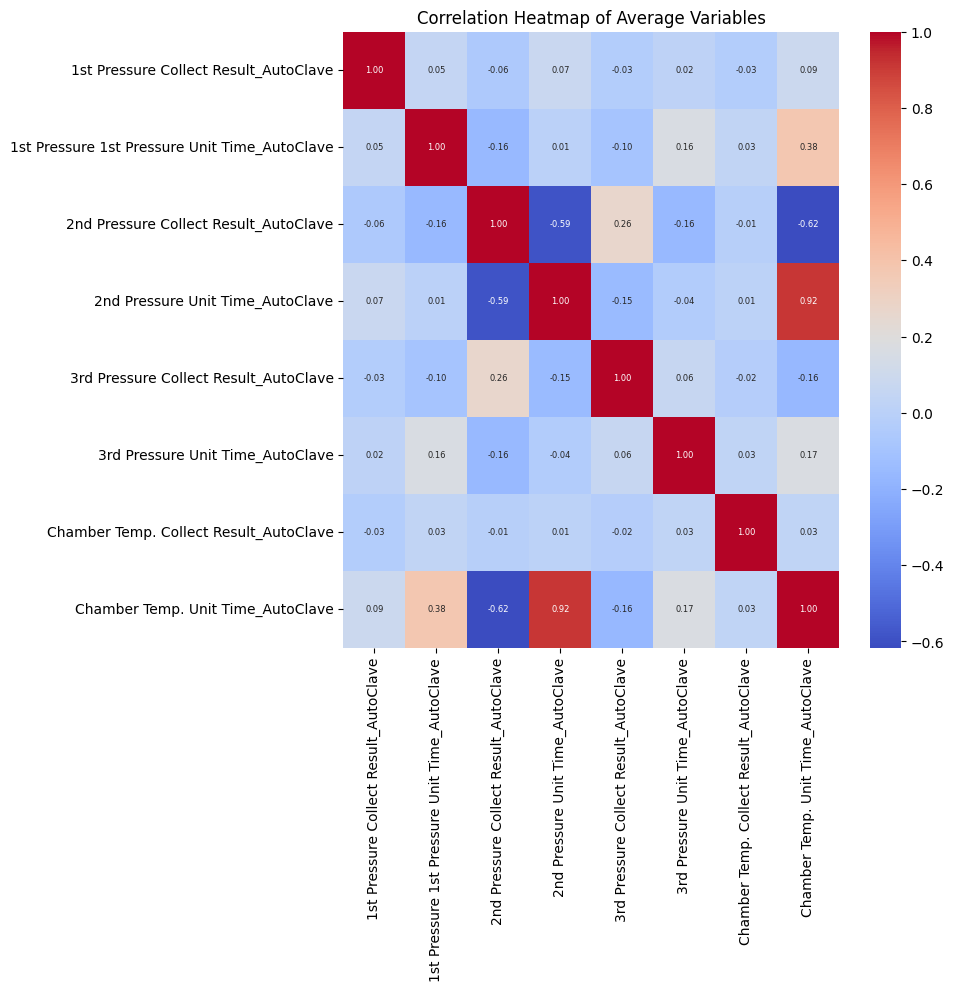

In [43]:
# 상관계수
variables = [
    '1st Pressure Collect Result_AutoClave',
'1st Pressure 1st Pressure Unit Time_AutoClave',
'2nd Pressure Collect Result_AutoClave',
'2nd Pressure Unit Time_AutoClave',
'3rd Pressure Collect Result_AutoClave',
'3rd Pressure Unit Time_AutoClave',
'Chamber Temp. Collect Result_AutoClave',
'Chamber Temp. Unit Time_AutoClave'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

### AutoClave

In [44]:
# 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

train_data = train_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'})
test_data = test_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'})

In [45]:
# 파생변수 생성
train_data['1st_Pressure_x_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure Unit Time_AutoClave'] 
test_data['1st_Pressure_x_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure Unit Time_AutoClave'] 

train_data['2nd_Pressure_x_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave'] 
test_data['2nd_Pressure_x_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave'] 

train_data['3rd_Pressure_x_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave'] 
test_data['3rd_Pressure_x_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave']

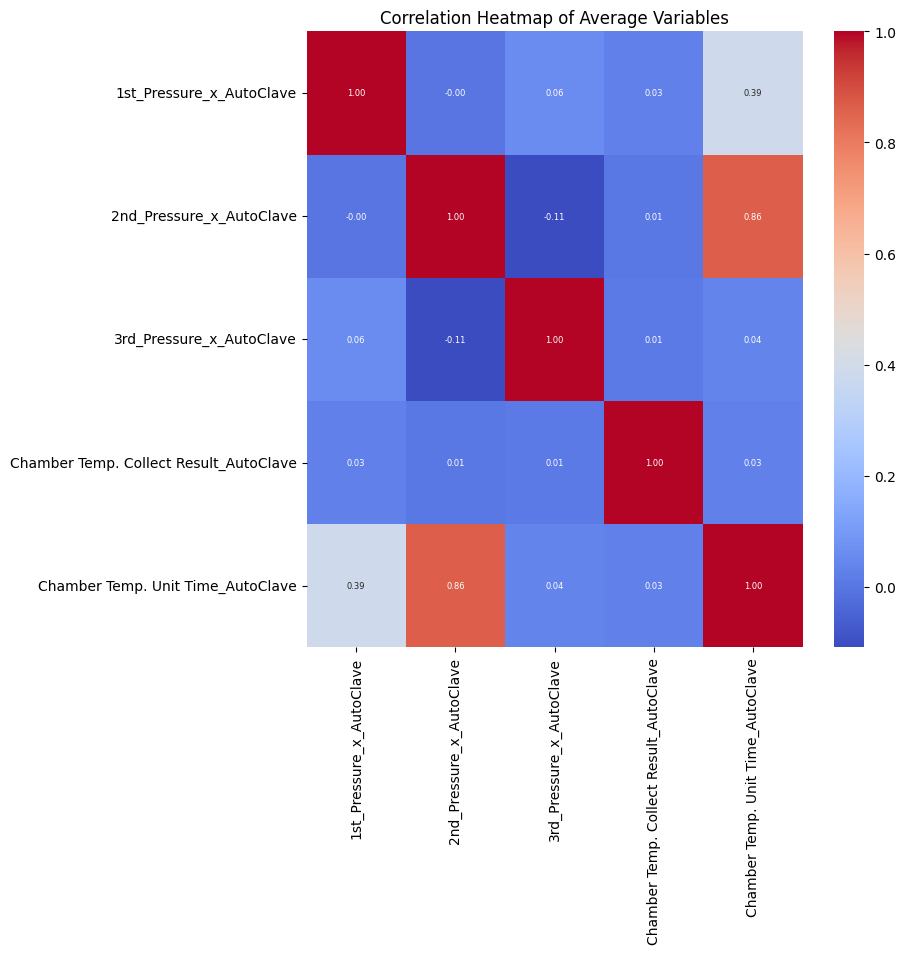

In [46]:
# 상관계수
variables = [
    '1st_Pressure_x_AutoClave',
'2nd_Pressure_x_AutoClave',
'3rd_Pressure_x_AutoClave',
'Chamber Temp. Collect Result_AutoClave',
'Chamber Temp. Unit Time_AutoClave'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [47]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave


In [48]:
# 변수 제거
train_data.drop(columns=[
    # 'Chamber Temp. Collect Result_AutoClave'
    #  'Chamber Temp. Unit Time_AutoClave'
     #'Chamber Temp. Judge Value_AutoClave'
     'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave',
     #'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
     '1st Pressure Collect Result_AutoClave',
     '1st Pressure Unit Time_AutoClave',
     '2nd Pressure Collect Result_AutoClave',
     '2nd Pressure Unit Time_AutoClave',
     '3rd Pressure Collect Result_AutoClave',
     '3rd Pressure Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    # 'Chamber Temp. Collect Result_AutoClave'
    #  'Chamber Temp. Unit Time_AutoClave'
     #'Chamber Temp. Judge Value_AutoClave'
     'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave',
    # 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    '1st Pressure Collect Result_AutoClave',
     '1st Pressure Unit Time_AutoClave',
     '2nd Pressure Collect Result_AutoClave',
     '2nd Pressure Unit Time_AutoClave',
     '3rd Pressure Collect Result_AutoClave',
     '3rd Pressure Unit Time_AutoClave'], inplace=True)

In [49]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave


### Fill1

In [50]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
Production Qty Collect Res

In [51]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Fill1'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [52]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
Production Qty Collect Res

In [53]:
# 필요한 열 이름
stage1_stage2_col = 'DISTANCE_STAGE1_STAGE2_Fill1'
stage2_stage3_col = 'DISTANCE_STAGE2_STAGE3_Fill1'
stage1_stage3_col = 'DISTANCE_STAGE1_STAGE3_Fill1'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['DISTANCE_TRIANGLE_area_Fill1'] = area
    data['DISTANCE_TRIANGLE_height_Fill1'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [54]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'DISTANCE_STAGE1_STAGE2_Fill1'
    , 'DISTANCE_STAGE2_STAGE3_Fill1'
    , 'DISTANCE_STAGE1_STAGE3_Fill1'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [55]:
# 변수 제거
train_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'], inplace=True)

test_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'], inplace=True)

In [56]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
Production Qty Collect Result_Fill1
DISTANCE_TRIANGLE_area_Fill1
DISTANCE_TRIANGLE_height_Fill1


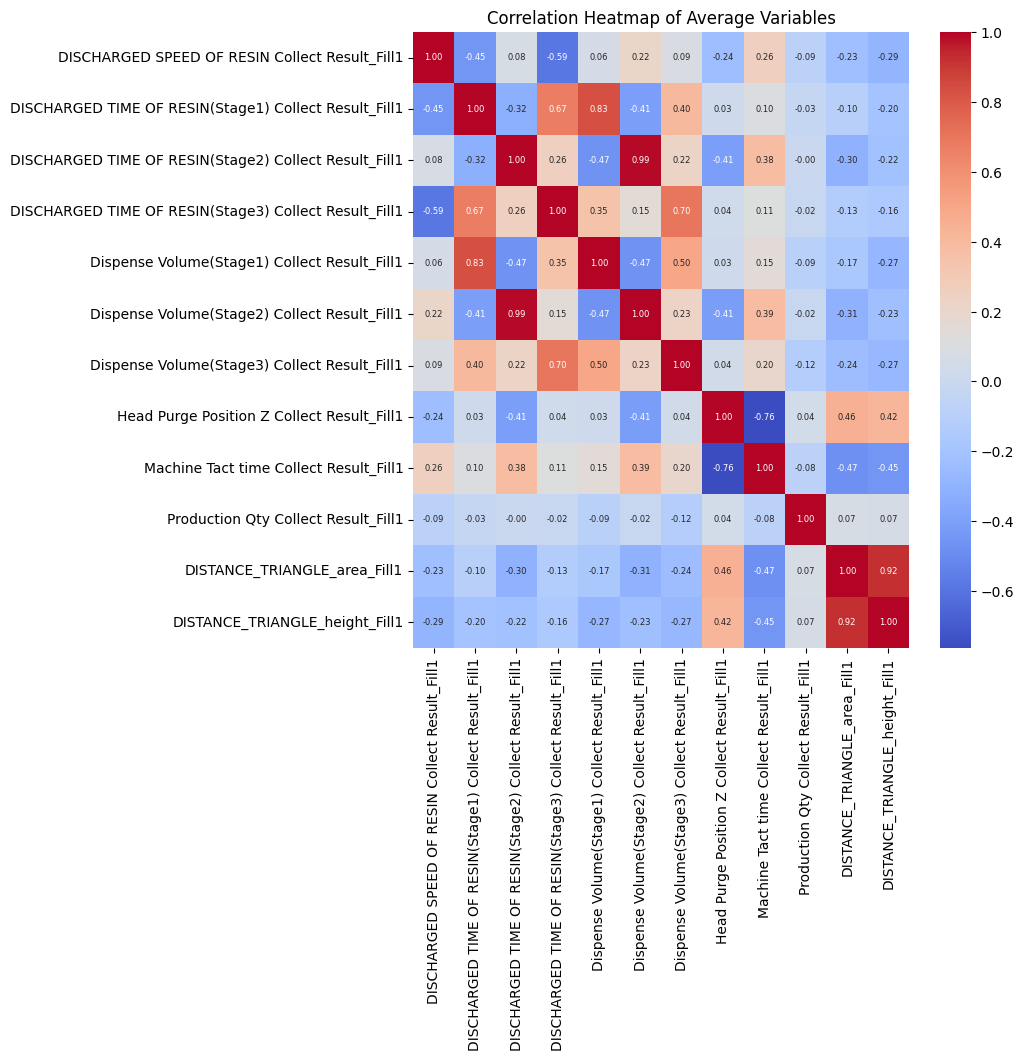

In [57]:
# 상관계수
variables = [
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
'Dispense Volume(Stage1) Collect Result_Fill1',
'Dispense Volume(Stage2) Collect Result_Fill1',
'Dispense Volume(Stage3) Collect Result_Fill1',
'Head Purge Position Z Collect Result_Fill1',
'Machine Tact time Collect Result_Fill1',
'Production Qty Collect Result_Fill1',
'DISTANCE_TRIANGLE_area_Fill1',
'DISTANCE_TRIANGLE_height_Fill1'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [58]:
# 파생변수 생성
train_data['1st_TIME_x_VOLUME'] = train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'] * train_data['Dispense Volume(Stage1) Collect Result_Fill1'] 
test_data['1st_TIME_x_VOLUME'] = test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'] * test_data['Dispense Volume(Stage1) Collect Result_Fill1'] 

train_data['2nd_TIME_X_VOLUME'] = train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'] * train_data['Dispense Volume(Stage2) Collect Result_Fill1'] 
test_data['2nd_TIME_X_VOLUME'] = test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'] * test_data['Dispense Volume(Stage2) Collect Result_Fill1']

train_data['2nd_TIME_X_VOLUME'] = train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'] * train_data['Dispense Volume(Stage3) Collect Result_Fill1'] 
test_data['2nd_TIME_X_VOLUME'] = test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'] * test_data['Dispense Volume(Stage3) Collect Result_Fill1'] 

In [59]:
# 변수 제거
train_data.drop(columns=[
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
'Dispense Volume(Stage1) Collect Result_Fill1',
'Dispense Volume(Stage2) Collect Result_Fill1',
'Dispense Volume(Stage3) Collect Result_Fill1'], inplace=True)

test_data.drop(columns=[
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
'Dispense Volume(Stage1) Collect Result_Fill1',
'Dispense Volume(Stage2) Collect Result_Fill1',
'Dispense Volume(Stage3) Collect Result_Fill1'], inplace=True)

In [60]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
Production Qty Collect Result_Fill1
DISTANCE_TRIANGLE_area_Fill1
DISTANCE_TRIANGLE_height_Fill1


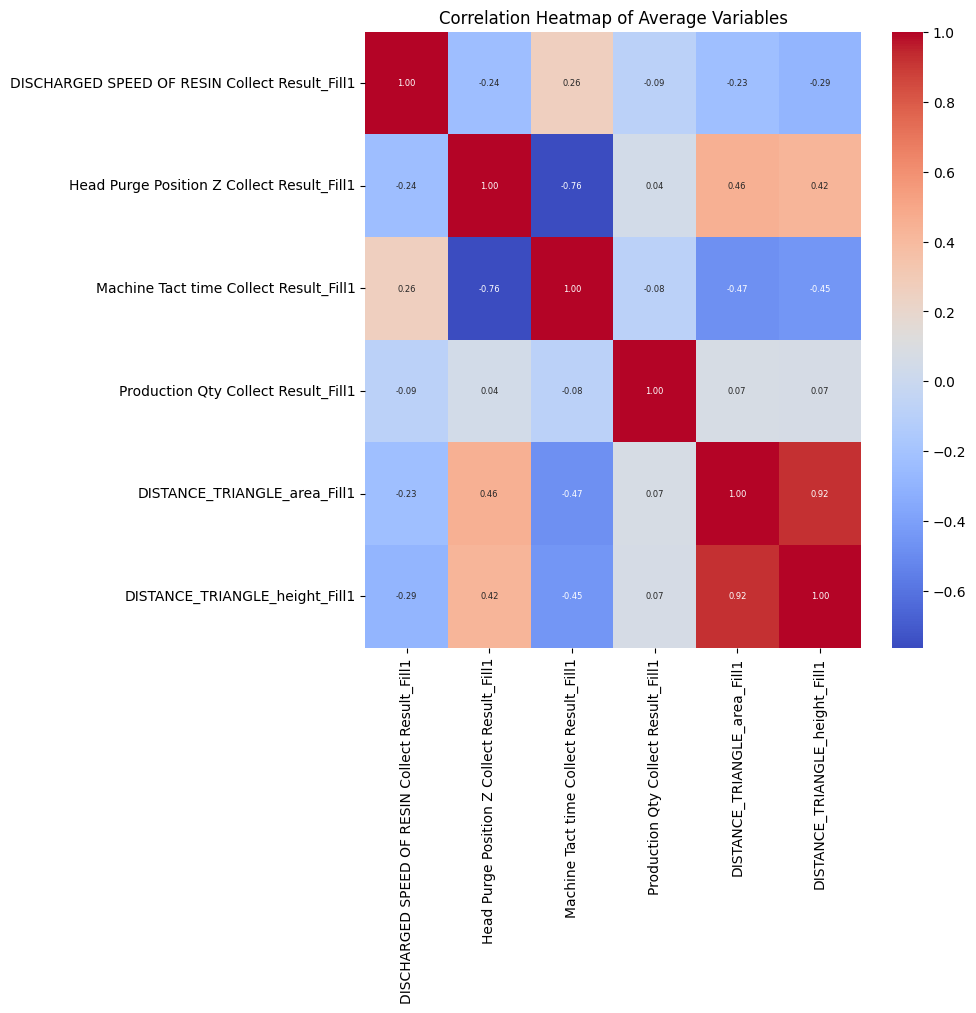

In [61]:
# 상관계수
variables = [
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
'Head Purge Position Z Collect Result_Fill1',
'Machine Tact time Collect Result_Fill1',
'Production Qty Collect Result_Fill1',
'DISTANCE_TRIANGLE_area_Fill1',
'DISTANCE_TRIANGLE_height_Fill1'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [62]:
# 변수 제거
train_data.drop(columns=[
    'DISTANCE_TRIANGLE_height_Fill1'], inplace=True)

test_data.drop(columns=[
    'DISTANCE_TRIANGLE_height_Fill1'], inplace=True)

### Fill2

In [63]:
# '_Fill2'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill2').columns

# 필터링된 열 이름 출력
print("<Fill2 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill2 공정 관련 변수>
CURE END POSITION X Collect Result_Fill2
CURE END POSITION Z Collect Result_Fill2
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE START POSITION X Collect Result_Fill2
CURE START POSITION Z Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2
Head Purge Position Z Collect Result_Fill2
Machine Tact time Collect Result_Fill2
Production Qty Collect Result_Fill2


In [64]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Fill2'
start_z_col = 'CURE START POSITION Z Collect Result_Fill2'
end_x_col = 'CURE END POSITION X Collect Result_Fill2'
end_z_col = 'CURE END POSITION Z Collect Result_Fill2'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

test_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

In [65]:
train_data['CURE_Time_Fill2']  = train_data['CURE_DISTANCE_Fill2'] / train_data['CURE SPEED Collect Result_Fill2']
test_data['CURE_Time_Fill2']  = test_data['CURE_DISTANCE_Fill2'] / test_data['CURE SPEED Collect Result_Fill2']

In [66]:
train_data['CURE_STANDBY_DISTANCE_Fill2']  = train_data['CURE START POSITION Z Collect Result_Fill2'] - train_data['CURE STANDBY POSITION Z Collect Result_Fill2']
test_data['CURE_STANDBY_DISTANCE_Fill2']  = test_data['CURE START POSITION Z Collect Result_Fill2'] - test_data['CURE STANDBY POSITION Z Collect Result_Fill2']

In [67]:
# 변수 제거
train_data.drop(columns=[
    'CURE END POSITION X Collect Result_Fill2'
    , 'CURE END POSITION Z Collect Result_Fill2'
    , 'CURE START POSITION X Collect Result_Fill2'
    , 'CURE START POSITION Z Collect Result_Fill2'
    , 'CURE_STANDBY_DISTANCE_Fill2'
    , 'CURE SPEED Collect Result_Fill2'], inplace=True)

test_data.drop(columns=[
    'CURE END POSITION X Collect Result_Fill2'
    , 'CURE END POSITION Z Collect Result_Fill2'
    , 'CURE START POSITION X Collect Result_Fill2'
    , 'CURE START POSITION Z Collect Result_Fill2'
    , 'CURE_STANDBY_DISTANCE_Fill2'
    , 'CURE SPEED Collect Result_Fill2'], inplace=True)

In [68]:
# CURE STANDBY POSITION Z Collect Result_Fill2 이름 변경
train_data.rename(columns={'CURE STANDBY POSITION Z Collect Result_Fill2': 'CURE_STANDBY_POSITION_Fill2'}, inplace=True)
test_data.rename(columns={'CURE STANDBY POSITION Z Collect Result_Fill2': 'CURE_STANDBY_POSITION_Fill2'}, inplace=True)

In [69]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Fill2'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [70]:
# 변수 제거
train_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'], inplace=True)

test_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'], inplace=True)

In [71]:
# '_Fill2'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill2').columns

# 필터링된 열 이름 출력
print("<Fill2 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill2 공정 관련 변수>
CURE_STANDBY_POSITION_Fill2
Head Purge Position Z Collect Result_Fill2
Machine Tact time Collect Result_Fill2
Production Qty Collect Result_Fill2
CURE_DISTANCE_Fill2
CURE_Time_Fill2
DISTANCE_STAGE1_STAGE2_Fill2
DISTANCE_STAGE2_STAGE3_Fill2
DISTANCE_STAGE1_STAGE3_Fill2


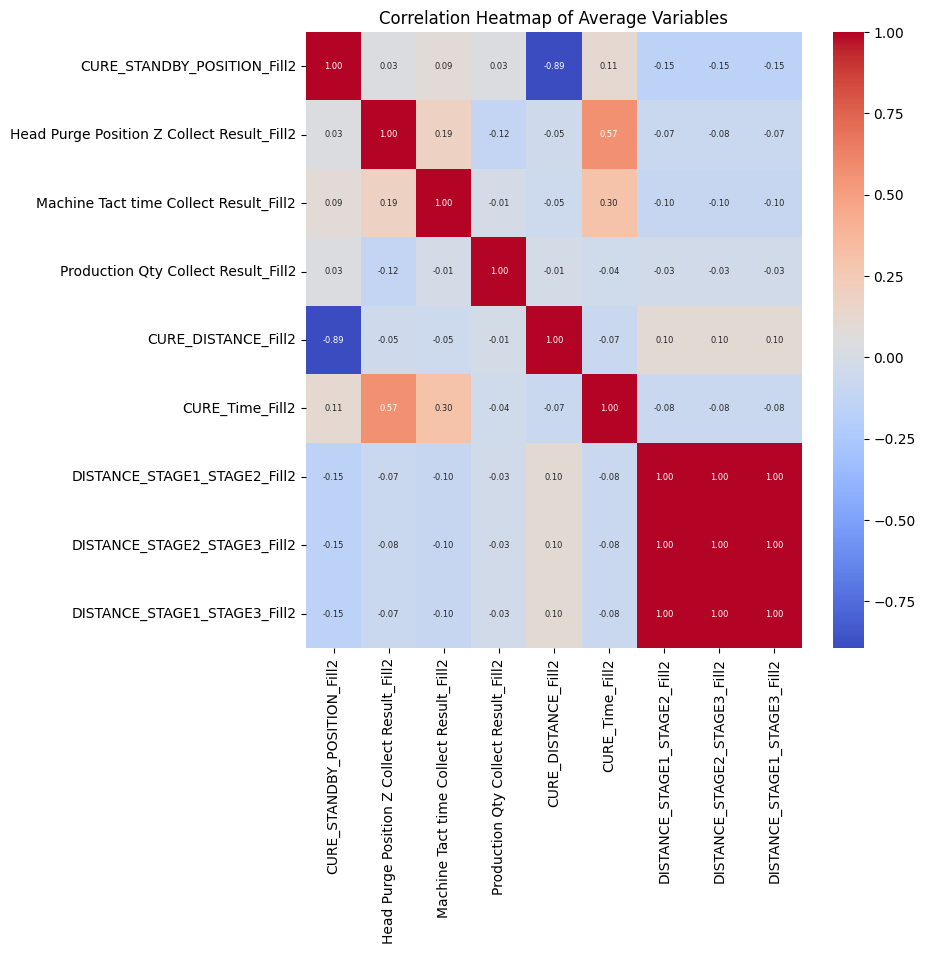

In [72]:
# 상관계수
variables = [
    'CURE_STANDBY_POSITION_Fill2',
'Head Purge Position Z Collect Result_Fill2',
'Machine Tact time Collect Result_Fill2',
'Production Qty Collect Result_Fill2',
'CURE_DISTANCE_Fill2',
'CURE_Time_Fill2',
'DISTANCE_STAGE1_STAGE2_Fill2',
'DISTANCE_STAGE2_STAGE3_Fill2',
'DISTANCE_STAGE1_STAGE3_Fill2',
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [73]:
# 변수 제거
train_data.drop(columns=[
    'CURE_DISTANCE_Fill2', 'DISTANCE_STAGE2_STAGE3_Fill2',
'DISTANCE_STAGE1_STAGE3_Fill2'], inplace=True)

test_data.drop(columns=[
    'CURE_DISTANCE_Fill2', 'DISTANCE_STAGE2_STAGE3_Fill2',
'DISTANCE_STAGE1_STAGE3_Fill2'], inplace=True)

In [74]:
# 'WorkOrder'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='work').columns

# 필터링된 열 이름 출력
print("<Work 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Work 관련 변수>
workorder_prefix


In [75]:
train_data['workorder_prefix'].value_counts()

workorder_prefix
3G1X    4608
3M1X    4586
3J1X    4057
4A1X    3962
3L1X    3665
3H1X    3322
3K1X    3176
4B1X    2855
4E1X    2696
3I1X    2227
4C1X    2103
3F1X    1276
4F1X     960
3LPM     153
4BPM     139
3KPM     123
3HPX     109
3JPX     100
3MPX      78
4BPX      68
3HPM      63
4CPM      53
4EPM      46
3FPM      24
3GPM      23
4APX      13
3KPX      11
4CPX       8
3FPX       2
Name: count, dtype: int64

In [76]:
train_data

,Model.Suffix,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,Production Qty Collect Result_Dam,WorkMode Collect Result,Chamber Temp. Collect Result_AutoClave,...,Total_THICKNESS_Collect_Result_Dam,Distance_frac_time_Dam,1st_Pressure_x_AutoClave,2nd_Pressure_x_AutoClave,3rd_Pressure_x_AutoClave,DISTANCE_TRIANGLE_area_Fill1,1st_TIME_x_VOLUME,2nd_TIME_X_VOLUME,CURE_Time_Fill2,DISTANCE_STAGE1_STAGE2_Fill2
0,AJX75334505,16,124.00,130.85,300.0,265.00,58.5,127,0.0,54,...,0.000000,2362.247350,74.880,0.493,59.880,125.095,153.162,150.822,16.250000,377.500013
1,AJX75334505,10,130.85,130.85,300.0,265.00,65.1,185,1.0,54,...,0.000000,2138.311367,74.951,37.631,60.258,56.985,173.070,173.070,15.600000,377.500013
2,AJX75334501,16,124.00,130.85,300.0,265.02,76.9,73,0.0,56,...,0.000637,1835.787256,75.915,0.490,60.258,264.940,173.070,170.582,15.600000,194.800000
3,AJX75334501,10,130.85,130.85,300.0,265.00,70.5,268,1.0,54,...,0.000000,1558.797305,72.059,36.300,60.500,162.465,173.070,173.070,15.600000,194.800000
4,AJX75334501,10,133.50,133.50,300.0,265.00,88.3,121,1.0,47,...,0.000000,2482.266138,72.480,36.240,59.760,45.225,173.070,173.070,15.600013,377.500013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,10,130.85,130.85,300.0,265.00,56.7,318,1.0,54,...,0.000000,2737.130159,72.300,36.300,60.500,56.985,173.070,173.070,15.600000,377.500013
40502,AJX75334501,16,124.00,130.85,300.0,265.00,78.5,197,0.0,49,...,0.014726,1796.212866,73.200,0.493,59.760,208.210,173.070,173.070,16.250000,195.000000
40503,AJX75334501,16,124.00,130.85,300.0,265.02,69.5,27,0.0,48,...,0.000000,2060.033094,74.469,0.490,60.258,159.210,158.025,158.025,15.600000,377.500013
40504,AJX75334501,10,130.85,130.85,300.0,265.00,57.7,117,1.0,54,...,0.000000,3845.033795,72.782,36.663,60.379,7.710,173.070,170.582,15.600000,194.800000


### Modeling

In [77]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = train_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
# print("결측값이 존재하는 변수명:", missing_columns)

Series([], dtype: int64)


In [78]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = test_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
# print("결측값이 존재하는 변수명:", missing_columns)

target    17361
dtype: int64


문자형(object) -> 수치형 변수

In [79]:
# Check all columns in the DataFrame
object_columns = train_data.select_dtypes(include=['object']).columns

# Print the result
print(f"Columns of type 'object': {list(object_columns)}")

Columns of type 'object': ['Model.Suffix', 'target', 'workorder_prefix']


In [80]:
# 'target' 열의 변수 타입을 object로 변경
# -> test 데이터는 float64 타입으로 되어있음 
test_data['target'] = test_data['target'].astype('object')

# object 타입의 변수 출력
train_object_columns = train_data.select_dtypes(include=['object']).columns
test_object_columns = test_data.select_dtypes(include=['object']).columns

print(train_object_columns, f" train_object_columns 갯수 : {len(train_object_columns)}")
print(test_object_columns, f" test_object_columns 갯수 : {len(test_object_columns)}")

# 각 object 변수의 고유 값 개수 출력
print("\nTrain Data:")
for col in train_object_columns:
    unique_count = train_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

print("\nTest Data:")
for col in test_object_columns:
    unique_count = test_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

Index(['Model.Suffix', 'target', 'workorder_prefix'], dtype='object')  train_object_columns 갯수 : 3
Index(['Set ID', 'Model.Suffix', 'target', 'workorder_prefix'], dtype='object')  test_object_columns 갯수 : 4

Train Data:
Model.Suffix unique 값 갯수: 7
target unique 값 갯수: 2
workorder_prefix unique 값 갯수: 29

Test Data:
Set ID unique 값 갯수: 17361
Model.Suffix unique 값 갯수: 7
target unique 값 갯수: 0
workorder_prefix unique 값 갯수: 29


In [81]:
# 타겟 변수와 범주형 변수 지정
## Target Encoding의 smoothing 파라미터는 default로 auto로 설정되어 있음
target = 'target'  # 타겟 변수 이름으로 변경
categorical_columns = [
    'Model.Suffix',
    'workorder_prefix'
]  # 범주형 변수 이름으로 변경

# 타겟 값을 숫자로 변환
target_mapping = {'Normal': 0, 'AbNormal': 1}
train_data[target] = train_data[target].map(target_mapping)
test_data[target] = test_data[target].map(target_mapping)

In [82]:
# 열이 존재하는지 확인
missing_columns = [col for col in categorical_columns if col not in train_data.columns]
if missing_columns:
    raise ValueError(f"train_data에 다음 열이 존재하지 않습니다: {missing_columns}")

# 타겟 인코더 생성 및 학습
encoder = ce.TargetEncoder(cols=categorical_columns)
train_data = encoder.fit_transform(train_data, train_data[target])

# Set ID 열을 별도로 저장
set_id = test_data['Set ID']

# 테스트 데이터 인코딩 (Set ID 열 제외)
test_data = test_data.drop(columns=['Set ID'])
test_data = encoder.transform(test_data)

# Set ID 열을 맨 앞에 추가
test_data.insert(0, 'Set ID', set_id)

In [83]:
train_data

,Model.Suffix,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,Production Qty Collect Result_Dam,WorkMode Collect Result,Chamber Temp. Collect Result_AutoClave,...,Total_THICKNESS_Collect_Result_Dam,Distance_frac_time_Dam,1st_Pressure_x_AutoClave,2nd_Pressure_x_AutoClave,3rd_Pressure_x_AutoClave,DISTANCE_TRIANGLE_area_Fill1,1st_TIME_x_VOLUME,2nd_TIME_X_VOLUME,CURE_Time_Fill2,DISTANCE_STAGE1_STAGE2_Fill2
0,0.049336,16,124.00,130.85,300.0,265.00,58.5,127,0.0,54,...,0.000000,2362.247350,74.880,0.493,59.880,125.095,153.162,150.822,16.250000,377.500013
1,0.049336,10,130.85,130.85,300.0,265.00,65.1,185,1.0,54,...,0.000000,2138.311367,74.951,37.631,60.258,56.985,173.070,173.070,15.600000,377.500013
2,0.056712,16,124.00,130.85,300.0,265.02,76.9,73,0.0,56,...,0.000637,1835.787256,75.915,0.490,60.258,264.940,173.070,170.582,15.600000,194.800000
3,0.056712,10,130.85,130.85,300.0,265.00,70.5,268,1.0,54,...,0.000000,1558.797305,72.059,36.300,60.500,162.465,173.070,173.070,15.600000,194.800000
4,0.056712,10,133.50,133.50,300.0,265.00,88.3,121,1.0,47,...,0.000000,2482.266138,72.480,36.240,59.760,45.225,173.070,173.070,15.600013,377.500013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,0.056712,10,130.85,130.85,300.0,265.00,56.7,318,1.0,54,...,0.000000,2737.130159,72.300,36.300,60.500,56.985,173.070,173.070,15.600000,377.500013
40502,0.056712,16,124.00,130.85,300.0,265.00,78.5,197,0.0,49,...,0.014726,1796.212866,73.200,0.493,59.760,208.210,173.070,173.070,16.250000,195.000000
40503,0.056712,16,124.00,130.85,300.0,265.02,69.5,27,0.0,48,...,0.000000,2060.033094,74.469,0.490,60.258,159.210,158.025,158.025,15.600000,377.500013
40504,0.056712,10,130.85,130.85,300.0,265.00,57.7,117,1.0,54,...,0.000000,3845.033795,72.782,36.663,60.379,7.710,173.070,170.582,15.600000,194.800000


In [84]:
# categorical_columns에 해당하는 열의 데이터 값만 확인
print(train_data[categorical_columns].head(3))
print(test_data[categorical_columns].head(3))

# 역 매핑 딕셔너리 생성
reverse_target_mapping = {v: k for k, v in target_mapping.items()}

# 타겟 값을 원래대로 변환
train_data[target] = train_data[target].map(reverse_target_mapping)
test_data[target] = test_data[target].map(reverse_target_mapping)

print("--- train_data ---")

# 변환된 타겟 값 확인
print(train_data[[target]].value_counts())

   Model.Suffix  workorder_prefix
0      0.049336          0.054167
1      0.049336          0.048781
2      0.056712          0.051929
   Model.Suffix  workorder_prefix
0      0.056712          0.046833
1      0.056712          0.038879
2      0.056712          0.080975
--- train_data ---
target  
Normal      38156
AbNormal     2350
Name: count, dtype: int64


### 데이터분할

In [85]:
RANDOM_STATE = 77

# 데이터셋 분할
x_train, x_val, y_train, y_val = train_test_split(
    train_data.drop("target", axis=1),
    train_data["target"],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE,
)

In [86]:
df_train, df_val = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)

def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 30524, AbNormal: 1880 ratio: 0.06159087930808544
  Total: Normal: 7632, AbNormal: 470 ratio: 0.061582809224318656


In [87]:
def get_clf_eval(y_test, y_pred_proba, threshold=0.5):
    # 확률을 기준으로 예측 레이블 생성
    y_pred = (y_pred_proba >= threshold).astype(int)  # 0.5 이상의 확률을 양성으로 간주

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Confusion Matrix:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [99]:
train_data.to_csv("train_data_model.csv", index=False)
test_data.to_csv("test_data_model.csv", index=False)

In [88]:
# LightGBM
#lgb_model = LGBMClassifier(
 #   n_estimators=1019
  #  , num_leaves=1513
  #  , max_depth=115
  #  , learning_rate=0.010329666890588058
  #  , min_child_samples=7
  #  , verbose = -1
  #  , boosting= 'dart'
  #  , random_state=RANDOM_STATE
#)

In [89]:
# df_train 데이터로 학습
#df_train["target"] = df_train["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

# features = df_train.columns.tolist()

#train_x = df_train.drop(columns=["target"])
#train_y = df_train["target"]

#lgb_model.fit(train_x, train_y)

In [90]:
# 검증 데이터 준비
#df_val["target"] = df_val["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

#val_x = df_val.drop(columns=["target"])
#val_y = df_val["target"]

# 확률 예측
#y_pred_proba = lgb_model.predict_proba(val_x)[:, 1]  # 양성 클래스에 대한 확률

# 모델 성능 평가
#get_clf_eval(val_y, y_pred_proba)


In [91]:
# df_train 데이터로 학습
#train_data["target"] = train_data["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

#train_x_all = train_data.drop(columns=["target"])
#train_y_all = train_data["target"]

#lgb_model.fit(train_x_all, train_y_all)

In [92]:
# 예측에 필요한 데이터 분리
#x_test = test_data.drop(["target", "Set ID"], axis=1)

# 테스트 데이터에 대한 예측 확률
#soft_voting_probs = lgb_model.predict_proba(x_test)[:, 1]

# 스레숄드 조절
#threshold = 0.5 #default
#soft_voting_preds = [1 if prob >= threshold else 0 for prob in soft_voting_probs]

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
#print(sum(soft_voting_preds))

In [93]:
# 예측에 필요한 데이터 분리
#x_test = test_data.drop(["target", "Set ID"], axis=1)

# 테스트 데이터에 대한 예측 확률
#soft_voting_probs = lgb_model.predict_proba(x_test)[:, 1]

# 스레스홀드 조절
#threshold = 0.2
#soft_voting_preds = [1 if prob >= threshold else 0 for prob in soft_voting_probs]

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
#print(sum(soft_voting_preds))

In [94]:
df_train["target"] = df_train["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)
df_val["target"] = df_val["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)


In [100]:
# Assuming 'train_data' is already loaded
# Creating a mapping for the target labels
target_mapping = {label: idx for idx, label in enumerate(train_data['target'].unique())}

# Preparing the train data by dropping the 'target' column for features
X = train_data.drop(columns=['target'])
y = train_data['target'].map(target_mapping)



In [102]:
y.value_counts()

target
0    38156
1     2350
Name: count, dtype: int64

In [105]:
# Calculating class weights based on the target class distribution
class_weights = {
    cls: len(y) / (len(np.where(y == cls)[0]) * len(np.unique(y)))
    for cls in np.unique(y)
}

# Applying these class weights to each sample
sample_weights = np.array([class_weights[cls] for cls in y])

# Splitting the data into training and validation sets while preserving sample weights
X_train, X_val, y_train, y_val, sample_weights_train, sample_weights_val = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# Creating the models with sample weights
xgb_model = XGBClassifier(max_depth=4,
    learning_rate=0.03369170868676631,
    n_estimators=818,
    min_child_weight=3)
cat_model = cb.CatBoostClassifier(depth=7,
    learning_rate=0.06966166550130459,
    iterations=516,
    auto_class_weights='Balanced',
    verbose=0,)

# Creating a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', cat_model)
], voting='soft')



Weighted F1 Score: 0.8432443030463577


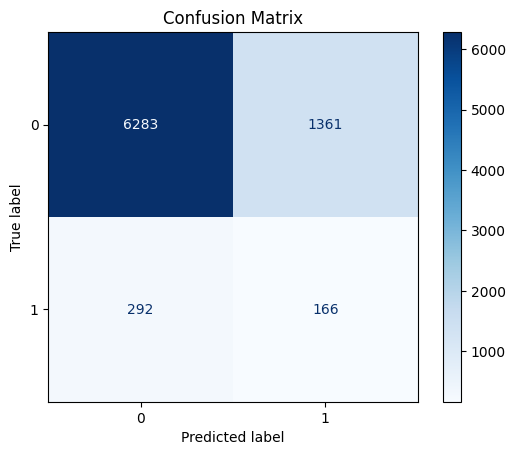

In [130]:
# Fitting the model with sample weights
voting_clf.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predicting on the validation set
y_val_pred = voting_clf.predict(X_val)

# Evaluating the model using f1_score
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Weighted F1 Score:", f1)

# Calculating the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap=plt.cm.Blues)

# Display the plot
plt.title("Confusion Matrix")
plt.show()

In [131]:
# 최종 모델 학습
voting_clf.fit(X, y, sample_weight=sample_weights)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...676631,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=818, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rf',
                              <catboost.core.CatBoostClassifier object at 0x000001732F86B3B0>)],
                 voting='soft')

In [112]:
test_data['target']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
17356    NaN
17357    NaN
17358    NaN
17359    NaN
17360    NaN
Name: target, Length: 17361, dtype: object

In [132]:
# Separating the 'Set ID' from the test data
set_ids = test_data['Set ID']
X_test = test_data.drop(["target", "Set ID"], axis=1)

# Predicting the target values using the trained voting classifier
y_test_pred = voting_clf.predict(X_test)

In [133]:
# Inverse mapping the predicted labels back to their original form
inverse_target_mapping = {v: k for k, v in target_mapping.items()}
y_test_pred_mapped = [inverse_target_mapping[pred] for pred in y_test_pred]

# Creating a DataFrame for the submission
submission = pd.DataFrame({
    'Set ID': set_ids,
    'target': y_test_pred_mapped
})

In [134]:
# Predicting the probabilities for the test set using soft voting
soft_voting_probs = voting_clf.predict_proba(X_test)[:, 1]

# Set the threshold
threshold = 0.1

# Apply the threshold to convert probabilities into binary predictions
soft_voting_preds = [1 if prob >= threshold else 0 for prob in soft_voting_probs]

# Inverse mapping the predicted labels back to their original form if needed
# (Assuming '1' corresponds to the positive class and '0' to the negative class)
inverse_target_mapping = {0: 'AbNormal', 1: 'Normal'}  # Example mapping, adjust as necessary
y_test_pred_mapped = [inverse_target_mapping[pred] for pred in soft_voting_preds]

# Creating a DataFrame for the submission
submission = pd.DataFrame({
    'Set ID': set_ids,
    'target': y_test_pred_mapped
})

In [135]:
submission['target'].value_counts()

target
Normal      16696
AbNormal      665
Name: count, dtype: int64

### 제출

In [136]:
# 제출 파일 저장
submission.to_csv("submission.csv", index=False)